In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from empiricaldist import Cdf, Pmf

  Created wheel for empiricaldist: filename=empiricaldist-0.6.0-py3-none-any.whl size=10354 sha256=d7c4edd509cb9dd708ad2bdf9175cf87aa792099fe4c1e1a4bc507924df384f8
  Stored in directory: /Users/alechuffman/Library/Caches/pip/wheels/3b/89/f4/9e4c6ab905d5f768398cc8bbf8cb5c5166cc9c9c36a7f4b8dc
Successfully built empiricaldist


## Let's get an overview of the data

In [2]:
df = pd.read_csv('Google-Playstore.csv')
df.head()


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice
0,HTTrack Website Copier,com.httrack.android,Communication,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,...,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False
1,World War 2: Offline Strategy,com.skizze.wwii,Strategy,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,...,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False
2,WPSApp,com.themausoft.wpsapp,Tools,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,...,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,Business,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,...,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False
4,Loud Player Free,com.arthelion.loudplayer,Music & Audio,4.2,665.0,"50,000+",50000.0,73463,True,0.0,...,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   App Id             1118136 non-null  object 
 2   Category           1118133 non-null  object 
 3   Rating             1111286 non-null  float64
 4   Rating Count       1111286 non-null  float64
 5   Installs           1117975 non-null  object 
 6   Minimum Installs   1117975 non-null  float64
 7   Maximum Installs   1118136 non-null  int64  
 8   Free               1118136 non-null  bool   
 9   Price              1118136 non-null  float64
 10  Currency           1117975 non-null  object 
 11  Size               1118136 non-null  object 
 12  Minimum Android    1116123 non-null  object 
 13  Developer Id       1118134 non-null  object 
 14  Developer Website  703770 non-null   object 
 15  Developer Email    1118114 non-n

In [4]:
df.isnull().sum()

App Name                  1
App Id                    0
Category                  3
Rating                 6850
Rating Count           6850
Installs                161
Minimum Installs        161
Maximum Installs          0
Free                      0
Price                     0
Currency                161
Size                      0
Minimum Android        2013
Developer Id              2
Developer Website    414366
Developer Email          22
Released               7730
Last Updated              0
Content Rating            0
Privacy Policy       153524
Ad Supported              0
In App Purchases          0
Editors Choice            0
dtype: int64

In [5]:
df['Category'].value_counts()

Education                  115242
Music & Audio              104541
Entertainment               82079
Books & Reference           78969
Personalization             73538
Tools                       68953
Lifestyle                   54586
Business                    42210
Health & Fitness            31532
Productivity                30450
Photography                 28942
Travel & Local              25971
Puzzle                      24954
Finance                     24846
Food & Drink                24250
Sports                      22094
News & Magazines            21553
Casual                      20509
Shopping                    20440
Communication               18391
Arcade                      17715
Social                      16987
Simulation                  15372
Action                      12628
Medical                     12554
Art & Design                12322
Educational                 11351
Maps & Navigation           10468
Adventure                   10124
Video Players 

## We can see that there are a few problems with the data:
1. There are many missing values in a few categories
2. Some columns don't really tell us any useful info like the ID, versions, currency, contact info etc.
3. All columns are not snake case or camel case
4. incorrect datatypes

### Let's start with problem 3 - All columns we'll be converted to snake case

In [6]:
df.rename(lambda x: x.lower().strip().replace(' ', '_'), 
            axis='columns', inplace=True)

### Now we'll fix problem 2 - Non-important columns will be dropped

In [9]:
to_drop = [
    'app_id', 'minimum_android', 'editors_choice',
    'developer_id', 'ad_supported', 'in_app_purchases', 'developer_website', 'developer_email', 'privacy_policy'     ]

df.drop(to_drop, axis='columns', inplace=True)

Looking back at our categories above, "Music and Audio" and "Music" are two separate categories - that will be fixed by combinning them together

"Education" and "Educational" are also two different categories - those will also be combined

In [11]:
df['category'] = df['category'].str.replace('Educational', 'Education')
df['category'] = df['category'].str.replace('Music & Audio', 'Music')



### Problem 4 - Fixing datatypes

In [13]:
df['size']

0                        2.7M
1                         86M
2                        5.8M
3                         59M
4                         29M
                  ...        
1118131    Varies with device
1118132                  4.7M
1118133                   28M
1118134                  8.1M
1118135                  8.8M
Name: size, Length: 1118136, dtype: object

We'll strip the megabytes/kb and convert this to a float64

In [14]:
df['size'] = pd.to_numeric(df['size'].str.replace(r'[a-zA-Z]+', ''), 
                             errors='coerce')

<ipython-input-14-f14b145b7478>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['size'] = pd.to_numeric(df['size'].str.replace(r'[a-zA-Z]+', ''),


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   app_name          1118135 non-null  object 
 1   category          1118133 non-null  object 
 2   rating            1111286 non-null  float64
 3   rating_count      1111286 non-null  float64
 4   installs          1117975 non-null  object 
 5   minimum_installs  1117975 non-null  float64
 6   maximum_installs  1118136 non-null  int64  
 7   free              1118136 non-null  bool   
 8   price             1118136 non-null  float64
 9   currency          1117975 non-null  object 
 10  size              1080403 non-null  float64
 11  released          1110406 non-null  object 
 12  last_updated      1118136 non-null  object 
 13  content_rating    1118136 non-null  object 
dtypes: bool(1), float64(5), int64(1), object(7)
memory usage: 112.0+ MB


### Now, some data exploration can be performed - Let's get a breakdown of categories

In [44]:
# Setting Google Colors
color_pal = ["#4285F4", "#DB4437", "#F4B400", "#0F9D58"]

Text(0.5, 1.0, 'Count of application according to category')

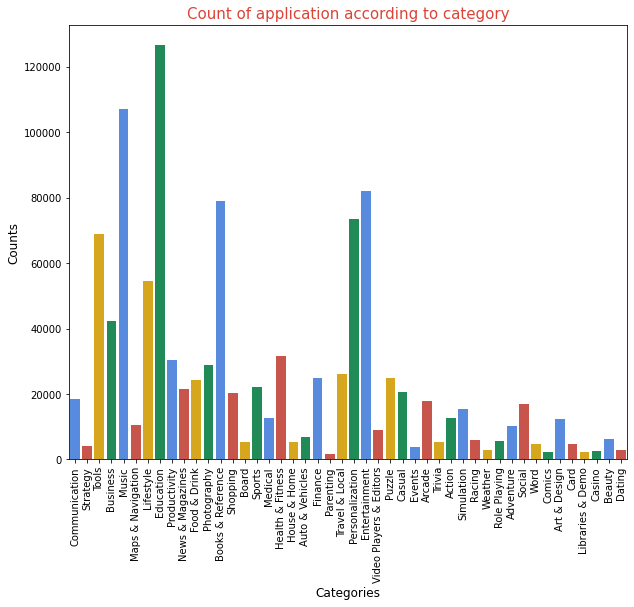

In [137]:
plt.figure(figsize=(10,8))
sns.countplot(x='category', data=df, palette=color_pal)
plt.xticks(rotation=90)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Count of application according to category', fontsize=15, color = color_pal[1])

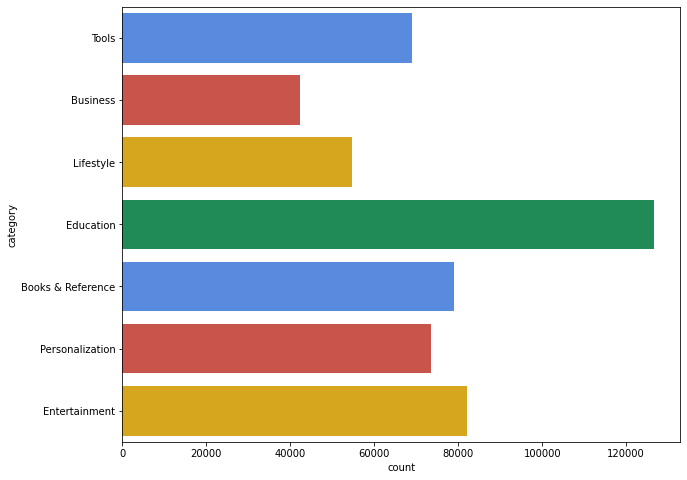

In [146]:
# Since there are so many categories we'll only work with the top ones
plt.figure(figsize=(10,8))
sns.set_palette(color_pal)
top_cats = ['Education', 'Music & Audio', 'Entertainment', 
           'Books & Reference', 'Personalization', 'Tools', 'Lifestyle', 'Business']
top_cats_df = df[df['category'].isin(top_cats)]
ax = sns.countplot(y="category", data=top_cats_df, palette=color_pal)
plt.show()

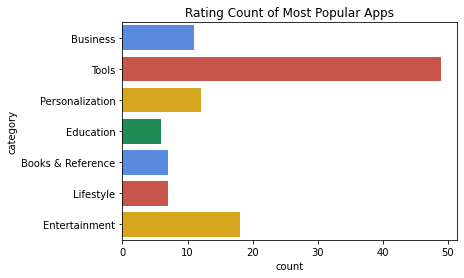

In [96]:
over_mln = top_cats_df[top_cats_df['rating_count'] > 1e6]
over_mln.shape
ax = sns.countplot(y="category", data=over_mln, palette=color_pal)
ax.set_title('Rating Count of Most Popular Apps')
plt.show();

<ipython-input-97-682751032088>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


[Text(0, 0.01, '0.3'),
 Text(0, 0.1, '0.5'),
 Text(0, 1.0, '1'),
 Text(0, 10.0, '3'),
 Text(0, 100.0, '5'),
 Text(0, 1000.0, '10'),
 Text(0, 10000.0, '30')]

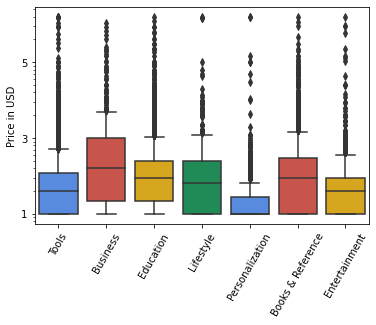

In [97]:
is_paid = top_cats_df['price'] != 0

ax = sns.boxplot(x='category', y='price', data=top_cats_df[is_paid], palette=color_pal)
ax.set(xlabel='', ylabel='Price in USD')
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
y_ticks = [0.3, 0.5, 1, 3, 5, 10, 30, 100, 300]
ax.set_yticklabels(y_ticks)

It looks like the majority of paid apps are within a few dollars

<ipython-input-115-22613f239586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cats_df['free'] = top_cats_df['free'].replace({True: 'Free', False: 'Paid'})


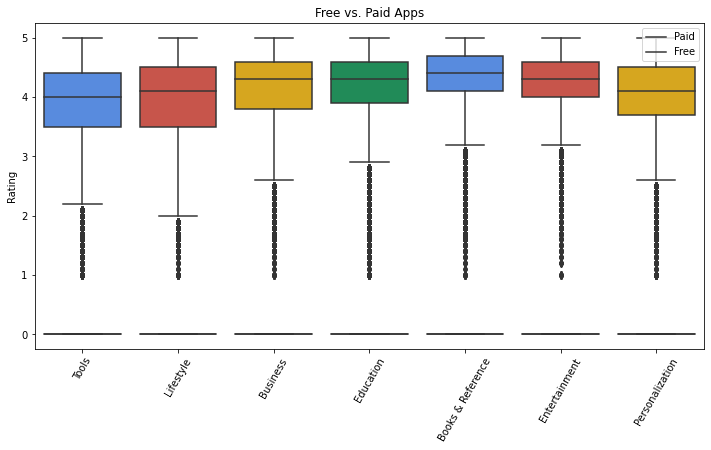

In [115]:
top_cats_df['free'] = top_cats_df['free'].replace({True: 'Free', False: 'Paid'})
is_paid = top_cats_df['price'] != 0
over_0 = top_cats_df[top_cats_df['rating'] > 0]

fig, ax = plt.subplots(figsize=(12, 6))



ax = sns.boxplot(x='category', y='rating', data=top_cats_df[top_cats_df['rating'] > 0],
           palette=color_pal)
ax.set(title='Comparison of Rating For Both Free And Paid Apps',
       xlabel='', ylabel='Rating')
ax.set_title('Free vs. Paid Apps')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.legend(['Paid', 'Free'], loc='upper right')
plt.show()


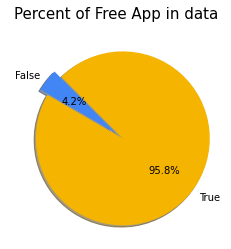

In [125]:
labels = df['free'].value_counts(sort = True).index
sizes = df['free'].value_counts(sort = True)
colors = ["#F4B400", "#4285F4"]

explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=150,)

plt.title('Percent of Free App in data', size = 15)
plt.show()

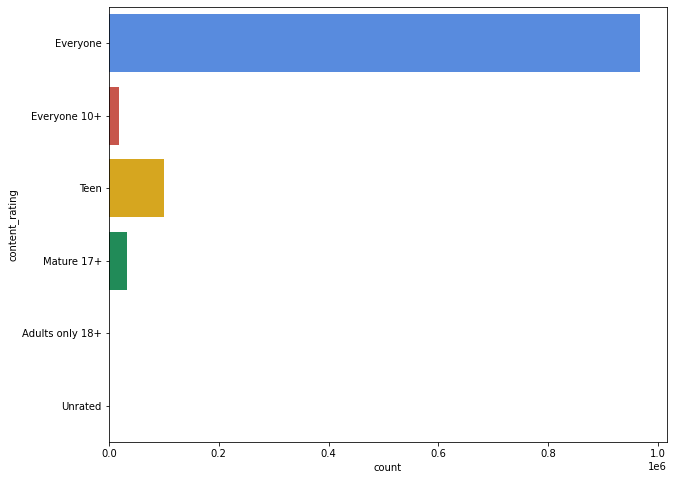

In [128]:
plt.figure(figsize=(10,8))
ax = sns.countplot(y='content_rating', data=df, palette=color_pal)